In [24]:
import time
start = time.time()
# libraries to analyze data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding
from sklearn.metrics import silhouette_score, calinski_harabaz_score
import seaborn as sns

end = time.time()
print('Loading libraries takes %.4fs' % (end-start))

Loading libraries takes 0.0116s


# 1. Reading training and testing features

In [2]:
path_data = '../data/' # path to the data
path_submission = '../submission/' # path to submission files

In [3]:
start = time.time()

# ====== read training features ====== #
orig_training_features = np.genfromtxt(path_data + 'training_features.csv', delimiter=',', skip_header=1, dtype=float)

end = time.time()
print('Reading training features takes %.4f s' % (end-start))

Reading training features takes 13.3386 s


In [4]:
start = time.time()

# ====== read testing features as str ====== #
orig_testing_features = np.genfromtxt(path_data + 'testing_features.csv', delimiter=',', skip_header=1, dtype=float)

end = time.time()
print('Reading testing features takes %.4f s' % (end-start))

Reading testing features takes 0.7362 s


In [5]:
start = time.time()

# ====== read training data as str ====== #
training = np.genfromtxt(path_data + 'training_set.txt', dtype=str)

# ====== extract labels ====== #
labels = training[:, 2].astype(int) # get the labels

end = time.time()
print('Reading training set & extracting labels takes %.4f s' % (end-start))

Reading training set & extracting labels takes 3.3402 s


In [6]:
start = time.time()
# these are the predicted labels highest rank in Kaggle
# ====== read testing features as str ====== #
test_label = np.genfromtxt(path_data + 'tuned_submission_gboost_01.csv', delimiter=',', skip_header=1)

end = time.time()
print('Reading testing_label features takes %.4f s' % (end-start))
test_label = test_label[:,1].astype(int)

Reading testing_label features takes 0.1589 s


In [7]:
print('Training features:', orig_training_features.shape)
print('Labels:', labels.shape)
print('Testing features:', orig_testing_features.shape)

print('training labels:', test_label.shape)

Training features: (615512, 18)
Labels: (615512,)
Testing features: (32648, 18)
training labels: (32648,)


# 2. Analysis

## 2.2 - Filtering out features

In [8]:
# list of selected features
orig_features = [
    'common_neighbors', # 0
    'jaccard', # 1
    'adamic_adar', # 2
    'in_kcore', # 3
    'katz_centrality', # 4
    'katz_linkpred', # 5
    'max_degrees', # 6
    'max_betweenness', # 7
    'max_pagerank', # 8
    'pref_attach', # 9
    'res_alloc', # 10
    'cos_tfidf', # 11
    'cos_w2v', # 12
    'cos_d2v', # 13
    'overlap_title', # 14
    'common_authors', # 15
    'temporal_diff', # 16
    'same_journal' # 17
]

In [9]:
# remove features
to_remove = [12, 13]
training_features = np.delete(orig_training_features, to_remove, 1)
testing_features = np.delete(orig_testing_features, to_remove, 1)
features = np.delete(orig_features, to_remove)

print('Training features:', training_features.shape)
print('Testing features:', testing_features.shape)


Training features: (615512, 16)
Testing features: (32648, 16)


## 2.2 - Analysis

### 2.2.A) Correlation between features 

/Users/Sina/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/Sina/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


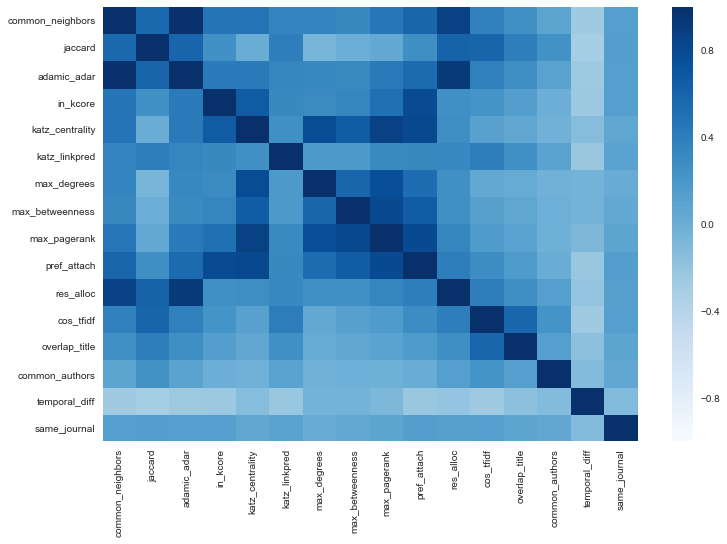

In [10]:
features_corr = np.corrcoef(training_features.T)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(features_corr, xticklabels = features, yticklabels = features, cmap="Blues")
plt.show()

### 2.2.B) Feature distribution

In [35]:
pd_training_features = pd.DataFrame(training_features, columns=features)
pd_testing_features = pd.DataFrame(testing_features, columns=features)
pd_labels = pd.DataFrame(labels)

In [12]:
pd_training_features.describe()

,common_neighbors,jaccard,adamic_adar,in_kcore,katz_centrality,katz_linkpred,max_degrees,max_betweenness,max_pagerank,pref_attach,res_alloc,cos_tfidf,overlap_title,common_authors,temporal_diff,same_journal
count,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000
mean,6.232439,0.058430,1.513243,0.564058,-4.878242,-10.194137,106.540634,11.460148,-9.654508,6.442046,0.125324,0.114068,0.495181,0.083410,2.795242,0.110368
std,11.137400,0.090385,2.740174,0.419826,0.684830,7.904377,239.809786,2.127001,0.869284,2.200320,0.247067,0.116394,0.862290,0.357317,2.434508,0.313348
min,0.000000,0.000000,0.000000,0.000000,-5.687178,-26.491587,0.000000,-2.197225,-12.126196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-5.423421,-18.181418,21.000000,10.376061,-10.221167,4.905275,0.000000,0.027508,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.011905,0.345976,0.500000,-5.008226,-5.278342,44.000000,11.492155,-9.807633,6.530878,0.018519,0.072819,0.000000,0.000000,2.000000,0.000000
75%,9.000000,0.087156,2.191180,1.000000,-4.559881,-5.231551,91.000000,12.563473,-9.272313,8.045588,0.180715,0.167300,1.000000,0.000000,4.000000,0.000000
max,1421.000000,0.880000,398.799149,1.000000,-1.897388,0.000000,2346.000000,17.968457,-6.085432,15.120571,44.127963,0.989114,9.000000,8.000000,11.000000,1.000000


In [13]:
pd_testing_features.describe()

,common_neighbors,jaccard,adamic_adar,in_kcore,katz_centrality,katz_linkpred,max_degrees,max_betweenness,max_pagerank,pref_attach,res_alloc,cos_tfidf,overlap_title,common_authors,temporal_diff,same_journal
count,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000
mean,6.159213,0.060706,1.498448,0.554766,-4.880698,-12.131125,107.563924,11.439569,-9.667390,6.378698,0.124805,0.113524,0.491393,0.082026,2.813741,0.109134
std,10.944711,0.096649,2.691890,0.418068,0.693057,7.009795,243.684146,2.155331,0.884438,2.223431,0.243233,0.116244,0.864580,0.350659,2.443407,0.311812
min,0.000000,0.000000,0.000000,0.000000,-5.687178,-26.491587,0.000000,-0.693147,-12.126196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-5.434166,-18.475682,20.000000,10.330326,-10.233916,4.836282,0.000000,0.027414,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.010471,0.309090,0.500000,-5.016616,-9.281015,43.000000,11.471153,-9.827842,6.445720,0.014878,0.071519,0.000000,0.000000,2.000000,0.000000
75%,9.000000,0.089109,2.162677,1.000000,-4.562177,-7.986707,91.000000,12.552499,-9.281255,7.996317,0.178629,0.166028,1.000000,0.000000,4.000000,0.000000
max,398.000000,1.000000,110.394619,1.000000,-1.897388,0.000000,2346.000000,17.968457,-6.085432,13.981057,13.728687,0.951020,7.000000,5.000000,11.000000,1.000000


In [14]:
#names =pd_training_features.dtypes.index

### 2.2.A) Visualization with t-sne and UMAP

In [15]:
%matplotlib inline
def plot_repr(X, y, title=""):
    d = X.shape[1]
    fig_kw = {"nrows": 1,
              "figsize": (2 * fw, 2 * fh)}
    subplot_kw = {}
    if d >= 3:
        subplot_kw = {"projection": "3d"}
    fig, ax = plt.subplots(**fig_kw, subplot_kw=subplot_kw)
    for i, yi in enumerate(set(y)):
        coords = []
        for j in range(min((d, 3))):
            coords.append(X[yi == y, j])
        scatter_kw = {"c": plt.cm.tab20(i),
                      "label": str(yi),
                      "marker": "o",
                      "edgecolors": "k",
                      "linewidths": 0.2}
        ax.scatter(*coords, **scatter_kw)
    ax.set_xlabel("$C_1$")
    ax.set_ylabel("$C_2$")
    if d >= 3:
        ax.set_zlabel("$C_3$")
    ax.set_title(title)
    ax.legend()
    return fig, ax

In [16]:
fw, fh = plt.rcParams["figure.figsize"]


In [17]:
training_features= training_features[0:20000]
labels= labels[0:20000]
testing_features=testing_features[0:20000]
test_label = test_label[0:20000]


In [72]:
from sklearn.decomposition import PCA
t = time.time()
my_pca = PCA(n_components=5).fit_transform(training_features)
t = time.time() - t
print(t)

0.05027508735656738


Computing t-SNE embedding


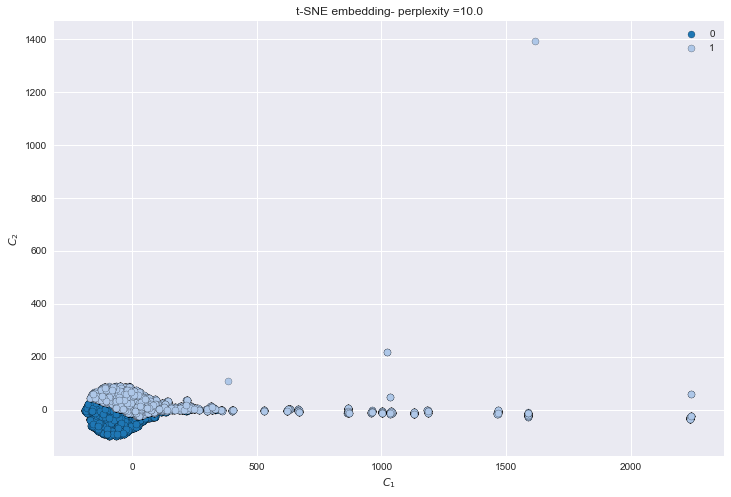

0.00012993812561035156


In [73]:
#Used t-Sne for visualizing data in only 2 dimensions. First PCA to reduce it to 5 dimensions to be faster.
res = pd.DataFrame(index=["Computation time", "Silhouette score", "Calinski-Harabazscore"])
print("Computing t-SNE embedding")
t =time.time()
tsne = TSNE(n_components=2, perplexity=10, init='pca', random_state=0)
t=time.time()-t
X_tsne = tsne.fit_transform(my_pca)
fig, ax1 = plot_repr(X_tsne, labels, title="t-SNE embedding- perplexity =10.0")
res.loc[:, ax1.get_title()] = (t, silhouette_score(X_tsne, labels), calinski_harabaz_score(X_tsne, labels))
plt.show()
print(t)

To install Umap used bellow for visualization: pip install umap-learn

Computing Umap


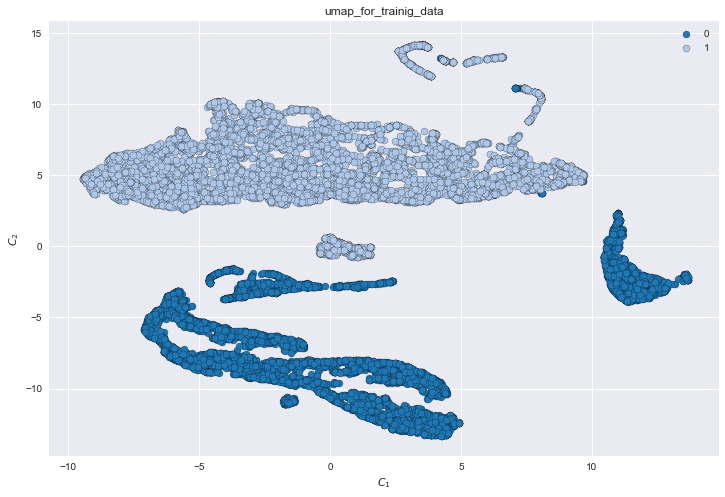

20.062862157821655
silhouette_score:  0.458798387418


In [66]:
#a very efficient method- very new
# Umap for training data
# we can see that two classes have been seperated almost perfectly- works much better than tsne
res = pd.DataFrame(index=["Computation time", "Silhouette score", "Calinski-Harabazscore"])
print("Computing Umap")
import umap
t = time.time()
X_umap = umap.UMAP(n_neighbors= 10, min_dist=0.01,metric='correlation').fit_transform(training_features)
t = time.time() - t
fig, ax = plot_repr(X_umap, labels, title="umap_for_trainig_data")
res.loc[:, ax.get_title()] = (t, silhouette_score(X_umap, labels), calinski_harabaz_score(X_umap, labels))
plt.show()
print(t)
print('silhouette_score: ',silhouette_score(X_umap, labels))

Computing Umap


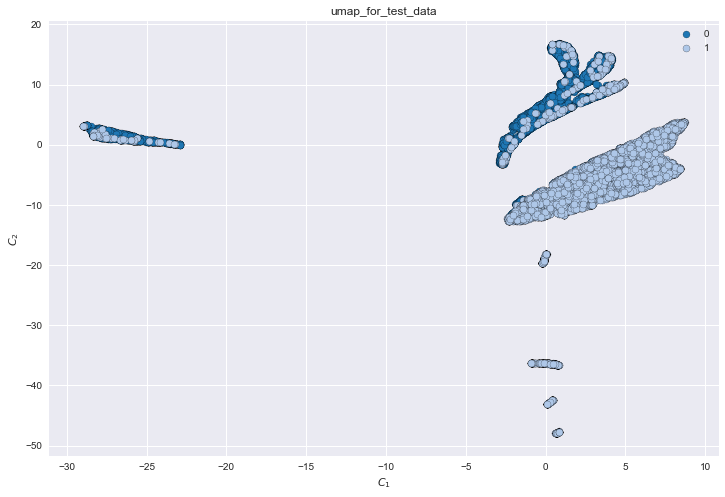

32.19938898086548
silhouette_score:  0.389847630581


In [67]:
# Umap for test data - labels from Kaggle final submission of xgboost
#a very efficient method
res = pd.DataFrame(index=["Computation time", "Silhouette score", "Calinski-Harabazscore"])
print("Computing Umap")
import time
import umap
t = time.time()
X_umap = umap.UMAP(n_neighbors= 30, min_dist=0.001,metric='correlation').fit_transform(testing_features)
t = time.time() - t
fig, ax = plot_repr(X_umap, test_label, title="umap_for_test_data")
res.loc[:, ax.get_title()] = (t, silhouette_score(X_umap, test_label), calinski_harabaz_score(X_umap, test_label))
plt.show()

print(t)
print('silhouette_score: ',silhouette_score(X_umap, test_label))

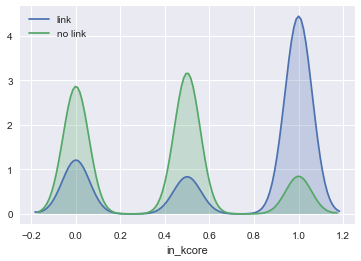

In [39]:
sns.kdeplot(pd_training_features.in_kcore[pd_labels[0] == 1], label='link', shade=True)
sns.kdeplot(pd_training_features.in_kcore[pd_labels[0] == 0], label='no link', shade=True)
plt.xlabel('in_kcore');

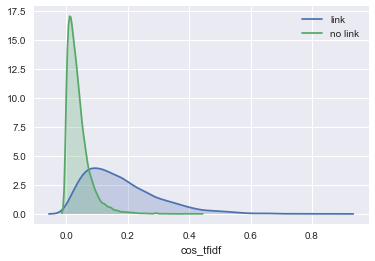

In [41]:
sns.kdeplot(pd_training_features.cos_tfidf[pd_labels[0] == 1], label='link', shade=True)
sns.kdeplot(pd_training_features.cos_tfidf[pd_labels[0] == 0], label='no link', shade=True)
plt.xlabel('cos_tfidf');

#when cosine similarity of two papers is more than a certain value, it's more probable that a  link exist between the two

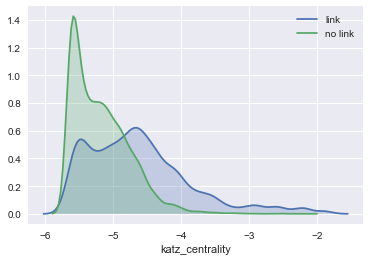

In [42]:
sns.kdeplot(pd_training_features.katz_centrality[pd_labels[0] == 1], label='link', shade=True)
sns.kdeplot(pd_training_features.katz_centrality[pd_labels[0] == 0], label='no link', shade=True)
plt.xlabel('katz_centrality'); 


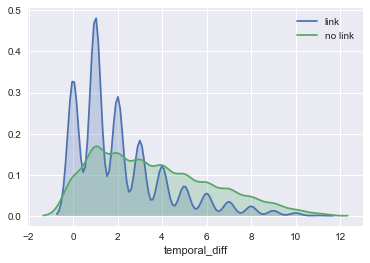

In [43]:
sns.kdeplot(pd_training_features.temporal_diff[pd_labels[0] == 1], label='link', shade=True)
sns.kdeplot(pd_training_features.temporal_diff[pd_labels[0] == 0], label='no link', shade=True)
plt.xlabel('temporal_diff');
# from the distribution of temporal difference:the lower the difference in the years of publication, more probable a link exist

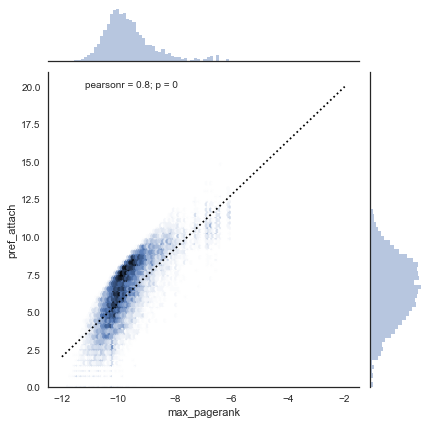

In [61]:
with sns.axes_style('white'): 
    g = sns.jointplot("max_pagerank", "pref_attach", pd_training_features, kind='hex')
    g.ax_joint.plot(np.linspace(-12, -2),
                    np.linspace(2, 20), ':k')
    
# to see the correlation between two correlated features: pref_attach & max_pagerank